# Part I: Исследование одной статистики на случайных графах
В этом ноутбуке мы исследуем поведение статистики $T^{knn} = Δ(G)$ и $T^{dist} = χ_{greedy}(G)$ при разных параметрах распределений и графов.

## 1. Импорт библиотек и настройка окружения

In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

In [14]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.data_utils import sample_stable, sample_normal
from src.build_graph import build_knn_graph, build_distance_graph
from src.graph_analyzer import GraphAnalyzer
from src.test_statistics import T_knn, T_dist
from src.mc_runner import run_mc_experiment, aggregate_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Генерация выборок и анализ с помощью Monte Carlo

In [12]:
configs = [
    {'dist': 'stable', 'params': {'alpha': 1.0}},
    {'dist': 'normal', 'params': {'sigma': 1.0}}
]
graph_types = ['knn', 'dist']
graph_params = {
    'knn': [5, 10],
    'dist': [0.5, 1.0]
}
n = 100
n_iter = 50

In [15]:
results_list = []
for cfg in configs:
    for gt in graph_types:
        for gp in graph_params[gt]:
            print(f"Запуск: dist={cfg['dist']}, graph={gt}, param={gp}")
            df = run_mc_experiment(
                dist=cfg['dist'],
                params=cfg['params'],
                graph_type=gt,
                graph_param=gp,
                n=n,
                n_iter=n_iter
            )
            results_list.append(df)

Запуск: dist=stable, graph=knn, param=5


MC stable-knn: 100%|██████████| 50/50 [00:00<00:00, 1042.89it/s]


Запуск: dist=stable, graph=knn, param=10


MC stable-knn: 100%|██████████| 50/50 [00:00<00:00, 846.61it/s]


Запуск: dist=stable, graph=dist, param=0.5


MC stable-dist: 100%|██████████| 50/50 [00:00<00:00, 157.72it/s]


Запуск: dist=stable, graph=dist, param=1.0


MC stable-dist: 100%|██████████| 50/50 [00:00<00:00, 91.85it/s]


Запуск: dist=normal, graph=knn, param=5


MC normal-knn: 100%|██████████| 50/50 [00:00<00:00, 1250.16it/s]


Запуск: dist=normal, graph=knn, param=10


MC normal-knn: 100%|██████████| 50/50 [00:00<00:00, 872.42it/s]


Запуск: dist=normal, graph=dist, param=0.5


MC normal-dist: 100%|██████████| 50/50 [00:00<00:00, 118.42it/s]


Запуск: dist=normal, graph=dist, param=1.0


MC normal-dist: 100%|██████████| 50/50 [00:00<00:00, 75.20it/s]


In [16]:
# Объединяем все результаты
results_df = pd.concat(results_list, ignore_index=True)
results_df.head()

,dist,alpha,graph_type,graph_param,n,stat,iter,sigma
0,stable,1.0,knn,5.0,100,10,0,NaN
1,stable,1.0,knn,5.0,100,10,1,NaN
2,stable,1.0,knn,5.0,100,9,2,NaN
3,stable,1.0,knn,5.0,100,10,3,NaN
4,stable,1.0,knn,5.0,100,9,4,NaN


## 5) Агрегация и просмотр статистик

In [17]:
agg = aggregate_results(results_df)
agg

,dist,graph_type,graph_param,n,mean,std
0,normal,dist,0.5,100,25.32,2.518827
1,normal,dist,1.0,100,42.94,3.688980
2,normal,knn,5.0,100,9.16,0.650275
3,normal,knn,10.0,100,17.00,0.880631
4,stable,dist,0.5,100,19.86,2.777534
5,stable,dist,1.0,100,32.82,3.305469
6,stable,knn,5.0,100,9.70,0.462910
7,stable,knn,10.0,100,18.36,0.875051


## 6) Визуализация результатов

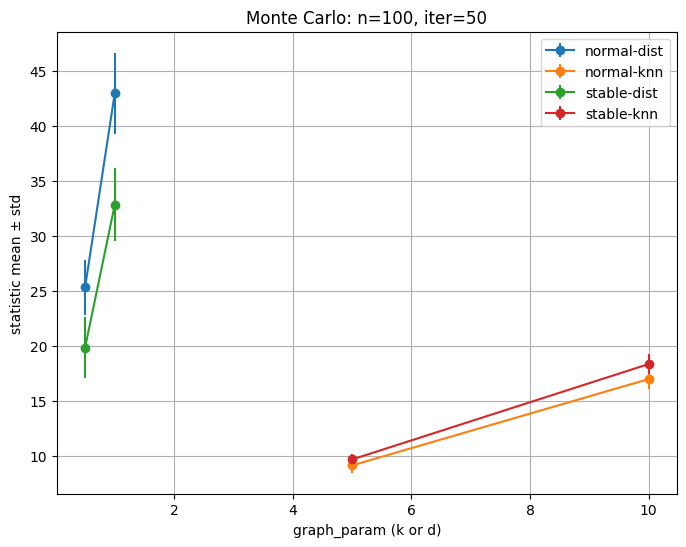

In [18]:
plt.figure(figsize=(8, 6))
for (dist, graph_type), group in agg.groupby(['dist', 'graph_type']):
    plt.errorbar(
        group['graph_param'],
        group['mean'],
        yerr=group['std'],
        fmt='o-',
        label=f"{dist}-{graph_type}"
    )

plt.xlabel('graph_param (k or d)')
plt.ylabel('statistic mean ± std')
plt.title(f"Monte Carlo: n={n}, iter={n_iter}")
plt.legend()
plt.grid(True)
plt.show()

## 7) распределение статистики

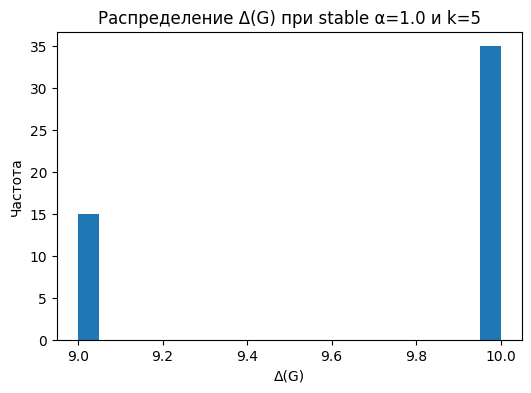

In [19]:
example = results_df[
    (results_df['dist']=='stable') &
    (results_df['graph_type']=='knn') &
    (results_df['graph_param']==5)
]
plt.figure(figsize=(6,4))
plt.hist(example['stat'], bins=20)
plt.title('Распределение Δ(G) при stable α=1.0 и k=5')
plt.xlabel('Δ(G)')
plt.ylabel('Частота')
plt.show()
